# Constructing and analyzing graphs for real data

#### In this notebook, we are going to use information realted to research articles on Diabetes 2 that have been scraped from pubmed (see the PubMed Scraper notebook on how to do that).








In [89]:
import os
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer


#!pip install  wordcloud
import textwrap
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
#from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


# igraph is a library for creating and manipulating graphs
import igraph as ig
# Import the gensim library for topic modeling and other NLP tasks
import gensim
# Import the 'simple_preprocess' function from gensim for text preprocessing
#from gensim.utils import simple_preprocess
# Import 'corpora' from gensim for working with textual data
import gensim.corpora as corpora
# Import 'pprint' from the 'pprint' library to pretty-print output
from pprint import pprint

# Import pyLDAvis and pyLDAvis.gensim for LDA visualization
import pyLDAvis.gensim
# Import pickle for saving and loading Python objects
import pickle
# Import pyLDAvis for LDA visualization
import pyLDAvis
# Import os for file path operations

# downloaf nltk data
nltk.download('punkt');
nltk.download('wordnet');
nltk.download('stopwords');

# set print options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import igraph as ig

In [91]:
import os
import shutil
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import  CountVectorizer


from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

# Import the gensim library for topic modeling and other NLP tasks
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

nltk.download('punkt');
nltk.download('wordnet');
nltk.download('stopwords');

import igraph as ig
import pandas as pd
import numpy as np
import cairo


[nltk_data] Downloading package punkt to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
def print_row(data, idx, target_column, symbols_per_line=100):
    """
    Print a row of a DataFrame with word wrapping

    Parameters
    ----------
    data : DataFrame
        The DataFrame containing the data to be printed
    idx : int
        The index of the row to be printed
    target_column : str
        The name of the column to be printed
    symbols_per_line : int
        The number of symbols per line at which to wrap the text
    
    Returns
    -------
    None
        
    """
    value = str(data[target_column].iloc[idx])
    print(target_column)
    
    # Remove excess spaces
    value = ' '.join(value.split())
    
    # Wrap text while respecting word boundaries
    wrapped_value = textwrap.fill(value, width=symbols_per_line)
    
    print(wrapped_value)
    return

def print_list(list, elements_per_line=10):
    """
    Print a list with a specified number of elements per line
    """

    list_range = range(0, len(list), elements_per_line)

    for i in list_range:
        print(*list[i:i+elements_per_line])
    return

# Define a function to find unique words in a text
def find_unique_words(text, word_list):
    """
    Find unique words in a text. Append the unique words to a list.
    """
    for word in text.split():
        if word not in word_list:
            word_list.append(word)
    return

#### Step 1: Read the data and have a look.  

In [100]:
data400 = pd.read_csv('type+2+diabetes_400.csv', index_col=0)
data500 = pd.read_csv('type+2+diabetes_500.csv', index_col=0)

# concatenate the two dataframes and drop duplicates
data = (pd.concat([data400, data500], axis=0)).drop_duplicates('ArticleTitle')
data.count()

Authors         491
ArticleTitle    506
Date            493
Abstract        203
Keywords         74
Affiliations    331
dtype: int64

Step 1: Clean the data. We'll make topics based on the keywords column and later use these as well as publication year to construct a graph

In [101]:
# drop rows with missing values in the 'Authors' and 'Date' column
data.dropna(subset=['Authors', 'Date'], inplace=True)

# Extract year and month from the 'Date' column
data['Year'] = (data['Date'].apply(lambda x: str(x)[-4:])).astype(int)

# Map month values Jan. Feb. etc. to numbers
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

extract_months = lambda x: np.nan if not '.' in x else months[x.split('.')[0]]
data['Month'] = (data['Date'].astype(str).apply(extract_months)).astype(float)

# In the following, we will make topics based on the keywords column. You could instead choose to work with the abstract column.
column_to_tokenize = 'Abstract'
target_column = column_to_tokenize + '_tokenized'

# drop rows with missing values column to tokenize
data.dropna(subset=[column_to_tokenize], inplace=True)
# make a new columns for the tokenized target column
data[target_column] = data[column_to_tokenize].astype(str)

# get rid of quataion marks 
data[target_column] = data[target_column].map(lambda x: x.strip('"').strip())

# Decapitalize text
data[target_column] = data[target_column].apply(lambda x: x.lower())
# Remove numbers
data[target_column] = data[target_column].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
# Remove punctuation
tokenizer = RegexpTokenizer(r'\w+')
data[target_column] = data[target_column].apply(lambda x: tokenizer.tokenize(x))

In [102]:
# drop rows where date column is nan
data = data.dropna(subset=['Date'])
# drop rows where date column is 'nan
data = data[data['Date'] != 'nan']

# In the following, we will make topics based on the keywords column. You could instead choose to work with the abstract column.
data.dropna(subset=['Keywords'], inplace=True)


In [105]:
# Let's find the no. of words and no. of unique words in the dataset

# Number of words in dataset
Nwords = data[target_column].apply(lambda x: len(x.split()));
unique_words_before_lemmatization = []

for row in data['Keywords']:
    find_unique_words(row, unique_words_before_lemmatization)

Nunique_words_before_lemmatization = len(unique_words_before_lemmatization);
# sort unique words
unique_words = sorted(unique_words_before_lemmatization);

print("Number of words in dataset: ", Nwords.sum())
print("Number of unique words in dataset: ", Nunique_words_before_lemmatization)
print(" The first 100 unique words: ", unique_words[:100])

AttributeError: 'list' object has no attribute 'split'

c:\Users\Simon Andersen\miniconda3\envs\BigData\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


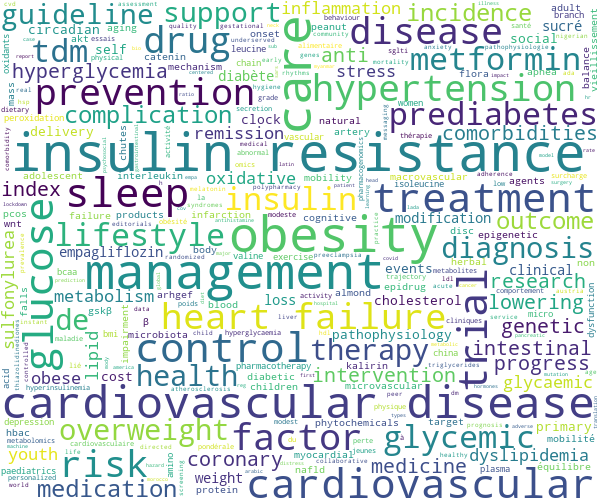

In [39]:
# Join the different processed titles together.
long_string = ','.join(list(data['Keywords'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',  width = 600, height = 500)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [40]:
# Define a function to convert sentences to words
def sent_to_words(sentences):
    # Loop over each sentence in the list of sentences
    for sentence in sentences:
        # Use gensim's simple_preprocess to convert the sentence to a list of words.
        # The 'deacc=True' argument removes punctuations.
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Get the 'text' column values from the 'data' DataFrame as a list
data_words = data.Keywords.values.tolist()

# Apply the 'sent_to_words' function to preprocess the data
# The result is a list of lists, where each inner list contains words from a sentence
data_words = list(sent_to_words(data_words))

In [41]:
# Create a Dictionary from the processed data_words
# The Dictionary object maps each unique word in the data to a unique integer ID
id2word = corpora.Dictionary(data_words)

# Create a Corpus using the original preprocessed data_words
# In this context, a "corpus" is simply a collection of documents (texts)
texts = data_words

# Create a Term Document Frequency corpus using the Dictionary
# 'doc2bow' counts the number of occurrences of each distinct word and converts the word to its integer ID
# The corpus is a list of vectors, one vector per document
corpus = [id2word.doc2bow(text) for text in texts]

# View a portion of the corpus to understand its structure
# The corpus is a list of lists, where each inner list contains tuples (word ID, word frequency) for a document
# The following line prints the all word IDs and frequencices for the first document in the corpus
print(corpus[:1][0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [42]:
# Set the number of topics to be extracted by the LDA model
num_topics = 3

# Build the LDA model using gensim's LdaMulticore
# 'corpus' contains the bag-of-words representation of each document
# 'id2word' is a dictionary that maps word IDs to actual words
# 'num_topics' specifies the number of topics to be extracted
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=42)

# Pretty-print the topics extracted by the LDA model
# Each topic is represented as a list of keywords and their associated weights
pprint(lda_model.print_topics())

# Apply the LDA model to the corpus to transform each document into a distribution of topics
# 'doc_lda' will contain the topic distribution for each document in the corpus
doc_lda = lda_model[corpus]

[(0,
  '0.020*"cardiovascular" + 0.020*"resistance" + 0.019*"insulin" + '
  '0.019*"care" + 0.013*"management" + 0.012*"treatment" + 0.010*"risk" + '
  '0.010*"control" + 0.010*"glucose" + 0.010*"obesity"'),
 (1,
  '0.018*"sleep" + 0.016*"incidence" + 0.015*"glycemic" + 0.015*"management" + '
  '0.015*"control" + 0.013*"cardiovascular" + 0.013*"support" + '
  '0.011*"insulin" + 0.011*"tdm" + 0.009*"cholesterol"'),
 (2,
  '0.027*"disease" + 0.017*"insulin" + 0.016*"obesity" + 0.016*"prevention" + '
  '0.015*"cardiovascular" + 0.012*"drug" + 0.012*"prediabetes" + '
  '0.012*"hypertension" + 0.011*"trials" + 0.011*"failure"')]


In [43]:
# Name topics
topic_0 = 'symptoms'
topic_1 = 'management'
topic_2 = 'risk factors'
topic_list = [topic_0, topic_1, topic_2]

In [44]:
# Import pyLDAvis and pyLDAvis.gensim for LDA visualization
import pyLDAvis.gensim
# Import pickle for saving and loading Python objects
import pickle
# Import pyLDAvis for LDA visualization
import pyLDAvis

# Enable the notebook mode for pyLDAvis
# This allows for interactive topic model visualization inline in a Jupyter Notebook
pyLDAvis.enable_notebook()

# Construct the filepath where the pre-prepared LDA visualization data will be saved
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))

# This block prepares LDA visualization and saves it
# The if statement here is always True (1 == 1), so the block will always execute
if 1 == 1:
    # Prepare LDA visualization using the LDA model, corpus, and dictionary
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    # Save the prepared visualization data to disk using pickle
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Load the pre-prepared LDA visualization data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# Save the LDA visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')

# Display the prepared LDA visualization
# Note: This would display the interactive LDA visualization inline if run in a Jupyter Notebook
LDAvis_prepared

c:\Users\Simon Andersen\miniconda3\envs\BigData\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.030842  0.052051       1        1  41.296257
2     -0.077292 -0.006565       2        1  36.365640
1      0.046450 -0.045486       3        1  22.338102, topic_info=               Term      Freq     Total Category  logprob  loglift
230       incidence  2.000000  2.000000  Default  30.0000  30.0000
64            sleep  3.000000  3.000000  Default  29.0000  29.0000
52         glycemic  2.000000  2.000000  Default  28.0000  28.0000
42          control  3.000000  3.000000  Default  27.0000  27.0000
83       prevention  3.000000  3.000000  Default  26.0000  26.0000
216         support  2.000000  2.000000  Default  25.0000  25.0000
10          disease  6.000000  6.000000  Default  24.0000  24.0000
82      prediabetes  2.000000  2.000000  Default  23.0000  23.0000
95              tdm  2.000000  2.000000  Default  22.0000  22.0000
173     cholesterol  1.000000  1.000000  Default  21.0000  21.0000
131          trials  2.000000  2.000000  Default  20.0000  20.0000
61     hypertension  2.000000  2.000000  Default  19.0000  19.0000
186      management  4.000000  4.000000  Default  18.0000  18.0000
127            care  5.000000  5.000000  Default  17.0000  17.0000
80        metformin  2.000000  2.000000  Default  16.0000  16.0000
224              dm  1.000000  1.000000  Default  15.0000  15.0000
221       adherence  1.000000  1.000000  Default  14.0000  14.0000
50           almond  1.000000  1.000000  Default  13.0000  13.0000
240            head  1.000000  1.000000  Default  12.0000  12.0000
238   antihistamine  1.000000  1.000000  Default  11.0000  11.0000
57           peanut  1.000000  1.000000  Default  10.0000  10.0000
51             body  1.000000  1.000000  Default   9.0000   9.0000
223             cvd  1.000000  1.000000  Default   8.0000   8.0000
110      depression  1.000000  1.000000  Default   7.0000   7.0000
241            neck  1.000000  1.000000  Default   6.0000   6.0000
117        vascular  1.000000  1.000000  Default   5.0000   5.0000
225      medication  1.000000  1.000000  Default   4.0000   4.0000
56             mass  1.000000  1.000000  Default   3.0000   3.0000
226     underserved  1.000000  1.000000  Default   2.0000   2.0000
239          cancer  1.000000  1.000000  Default   1.0000   1.0000
108          stress  1.603415  1.994815   Topic1  -4.7460   0.6660
102      metabolism  1.602279  1.994552   Topic1  -4.7467   0.6654
105       oxidative  1.601155  1.993720   Topic1  -4.7474   0.6651
125   empagliflozin  1.452463  1.950212   Topic1  -4.8449   0.5897
189          events  1.436809  1.946539   Topic1  -4.8557   0.5808
107          plasma  0.923522  1.297646   Topic1  -5.2977   0.5443
251            sars  0.923549  1.297760   Topic1  -5.2977   0.5442
103           lipid  0.922672  1.297517   Topic1  -5.2986   0.5435
246             cov  0.922446  1.297540   Topic1  -5.2989   0.5432
248          impact  0.921881  1.297393   Topic1  -5.2995   0.5427
106    peroxidation  0.921567  1.297116   Topic1  -5.2998   0.5426
104        oxidants  0.921705  1.297388   Topic1  -5.2997   0.5425
249        lockdown  0.920325  1.296989   Topic1  -5.3012   0.5413
250         morocco  0.920334  1.297058   Topic1  -5.3012   0.5413
247           covid  0.919766  1.296974   Topic1  -5.3018   0.5407
100        exercise  0.919358  1.296642   Topic1  -5.3022   0.5405
48          protein  0.918415  1.296613   Topic1  -5.3033   0.5395
41            blood  0.917683  1.296401   Topic1  -5.3041   0.5389
49           target  0.917649  1.296477   Topic1  -5.3041   0.5388
45          epidrug  0.917555  1.296410   Topic1  -5.3042   0.5388
129    personalized  0.915842  1.295833   Topic1  -5.3061   0.5373
199       mortality  0.914924  1.295556   Topic1  -5.3071   0.5365
0            factor  0.914951  1.295698   Topic1  -5.3070   0.5365
196     comorbidity  0.914936  1.295864   Topic1  -5.3071   0.5363
19

The doc_lda contains the probability that each document belong to each of the topics. We are going to add this data to the dataframe

In [45]:
# Construct array of topic probabilities for each document in the corpus
topic_probability_array = np.zeros([len(data), num_topics])
main_topic_list = []

# extract topic probabilities for each document
for i, doc in enumerate(doc_lda):
    for topic in doc:
        topic_probability_array[i, topic[0]] = topic[1]
    main_topic_list.append(topic_list[np.argmax(topic_probability_array[i, :])])

# add topic probabilities to dataframe
for topic in topic_list:
    #data['Main Topic'] = topic_probability_array[np.argmax(topic_probability_array, axis=1)]
    
    data[f"Topic: {topic}"] = topic_probability_array[:, topic_list.index(topic)]

# add main topic to dataframe
data['Main topic'] = main_topic_list

In [48]:
# let's have a look
data.head()

,Authors,ArticleTitle,Date,Abstract,Keywords,Affiliations,Topic: symptoms,Topic: management,Topic: risk factors,Main topic
0,"Y. Wu, Y. Ding, Y. Tanaka and W. Zhang,","""Risk factors contributing to type 2 diabetes ...",2014,"""Type 2 diabetes is a serious and common chron...",genetic factor intervention trial lifestyle tr...,"""1. Lab of Molecular Immunology, Zhejiang Prov...",0.898579,0.050625,0.050797,symptoms
6,"RJ. Henning,","""Type-2 diabetes mellitus and cardiovascular d...",2018,"""The global prevalence of diabetes has risen i...",hbac adult onset coronary artery disease gluco...,"""University of South Florida, Tampa, FL 33612-...",0.016267,0.015503,0.968230,risk factors
7,"J. Damanik and E. Yunir,","""Type 2 Diabetes Mellitus and Cognitive Impair...",2021,"""Type 2 diabetes mellitus (T2DM) is strongly a...",cognitive impairment,"""Department of Internal Medicine, Faculty of M...",0.112508,0.112902,0.774590,risk factors
8,"Q. Ma, Y. Li, P. Li, M. Wang, J. Wang, Z. Tang...","""Research progress in the relationship between...",2019,"""Type 2 diabetes mellitus (T2DM) is a common c...",intestinal flora research progress,"""School of Chinese Materia Medica, Beijing Uni...",0.079279,0.067593,0.853128,risk factors
11,"L. Xu, Y. Li, Y. Dai and J. Peng,","""Natural products for the treatment of type 2 ...",2018,"""Epidemiological studies have implied that dia...",anti diabetic drug herbal medicine mechanism n...,"""College of Pharmacy, Dalian Medical Universit...",0.038977,0.037414,0.923609,risk factors


In [49]:
def make_edge_list(dataframe, column_name):
    """This function takes a dataframe and a column name as input and returns a list of edges for a graph, 
    where an edge is defined as a pair of nodes that share the same value in the specified column."""
    edge_list = []
    for i in range(len(dataframe)):
        for j in range(i+1, len(dataframe)):
            if dataframe[column_name].iloc[i] == dataframe[column_name].iloc[j]:
                edge_list.append((i, j))
    return edge_list

Let's construct a graph

In [64]:
# Make a graph, where each article is a node and edges are defined as topic similarity
g = ig.Graph(n = len(data))

# Add attributes to nodes
g.vs["name"] = data['ArticleTitle'].to_list()

# Add Authors
g.vs["author"] = data['Authors'].to_list()

# Add year
g.vs["year"] = data['Date'].to_list()

# Add topic
g.vs["topic"] = data['Main topic'].to_list()

colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'black']
# Add vertex colors based on topic
color_dict = {f'{topic}': f'{color}' for topic, color in zip(topic_list, colors)}

g.vs["color"] = [color_dict[topic] for topic in g.vs["topic"]]


In [63]:
g.vs

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, 0 to 372
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Authors              62 non-null     object 
 1   ArticleTitle         62 non-null     object 
 2   Date                 62 non-null     object 
 3   Abstract             59 non-null     object 
 4   Keywords             62 non-null     object 
 5   Affiliations         62 non-null     object 
 6   Topic: symptoms      62 non-null     float64
 7   Topic: management    62 non-null     float64
 8   Topic: risk factors  62 non-null     float64
 9   Main topic           62 non-null     object 
dtypes: float64(3), object(7)
memory usage: 5.3+ KB


We are going to make edges between articles published in the same year, while also keeping track of whether those articles belong to the same topic (so we can make those edges thicker)

In [65]:
# Make edge list that connects documents that share the same publication year
edges = make_edge_list(data, 'Date')

# add edges attribute to show which edges are between documents that share the same main topic
same_topic_list = list([True] * len(edges))
for i, edge in enumerate(edges):
    if data['Main topic'].iloc[edge[0]] == data['Main topic'].iloc[edge[1]]:
        pass
    else:
        same_topic_list[i] = False
# add edges to grph
g.add_edges(edges)

g.es["same_topic"] = same_topic_list

In [68]:
# Possible layouts
l1 = g.layout('circle')
l2 = g.layout('drl')
l3 = g.layout('fr')
l4 = g.layout('kk')
l5 = g.layout('random')
l6 = g.layout('rt')
l7 = g.layout('rt_circular')

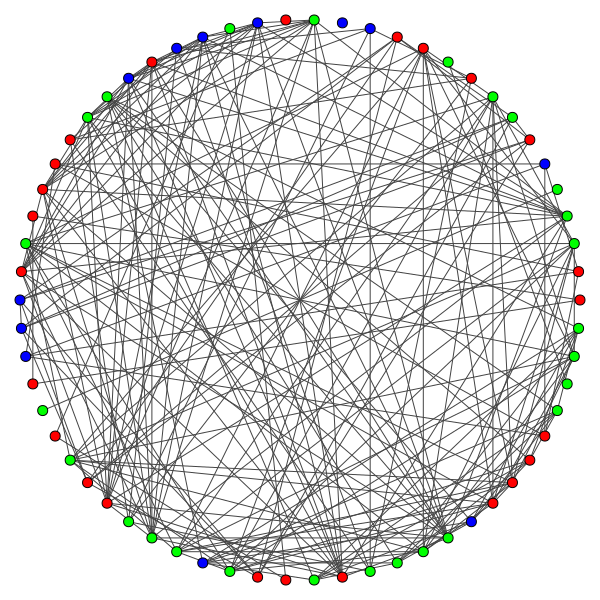

In [80]:
visual_style = {}
visual_style["vertex_size"] = 10

#visual_style["bbox"] = (600, 600)
#visual_style["margin"] = 5

# Make edge thicker if they are between documents that share the same main topic
#visual_style["edge_width"] = [1 + 2 * int(same_topic) for same_topic in g.es["same_topic"]] #change the width of edges based on the "is_formal" attribute
ig.plot(g, layout=l1, **visual_style)

#### Exercise:

This excercise is very free. You are encouraged to play around with it and try out ideas. Suggestions for things to try out:
- Extract basic information about the graph like we did in the toyexample notebook
- Change the number of topics
- Play around with the graph layout
- Add edges by either:
1)  connecting articles that are published 1 year apart
2) Including affiliation information into the graph (e.g. make edges between vertices that have affiliations from the same countries)
3) Something else you find interesting

- Make the LDA analysis based on the abstracts and not the keywords
- Change it up completely and make edges based on topic and color vertices by year instead

